Para las preguntas 1,2,3 y 4 emplea el dataset train.csv Para la pregunta 5 deberás emplear el dataset 'train.csv' y 'test_X.csv'.

- ¿Cuáles son los 3 paises en los que más pedidos se realizan?
- ¿Cuáles son las horas en las que se realizan más pedidos en España?
- ¿Cuál es el precio medio por pedido en la tienda con ID 12513?
- Teniendo en cuenta los picos de demanda en España, si los repartidores trabajan en turnos de 8horas.
Turno 1 (00:00-08:00)
Turno 2 (08:00-16:00)
Turno 3 (16:00-00:00)
Qué porcentaje de repartidores pondrías por cada turno para que sean capaces de hacer frente a los picos de demanda. (ej: Turno 1 el 30%, Turno 2 el 10% y Turno 3 el 60%).

- Realiza un modelo predictivo de machine learning a partir del dataset 'train.csv' en el cual a partir de las variables predictoras que se entregan en el dataset 'test_X' se pueda predecir si el pedido se cancelará o no (columna 'final_status').

# import libraries

In [3]:
import numpy as np
import pandas as pd

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

from numpy import random
random.seed(17)

# Import data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# archivo csv separado con ','
df_train = pd.read_csv("/content/drive/MyDrive/T.I.C./challenge/nuwe/IT JUNIOR Hackathon - JOBMadrid'22/train.csv")

# archivo csv separado con ';'
df_test_X = pd.read_csv("/content/drive/MyDrive/T.I.C./challenge/nuwe/IT JUNIOR Hackathon - JOBMadrid'22/test_X.csv", sep=';')

# data analysis

## vistazo general

In [6]:
df_train.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,33446280,14:11:09,AR,55379,PAID,2,11.88,DeliveredStatus
1,33107339,11:47:41,GT,23487,PAID,2,5.20,DeliveredStatus
2,32960645,11:53:53,CR,62229,PAID,1,6.03,DeliveredStatus
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
4,32157739,21:32:16,AR,13917,PAID,1,5.36,CanceledStatus


In [7]:
df_test_X.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total
0,32233784,17:50:09,MA,68169,PAID,1,61.63
1,32240990,18:38:08,ES,8220,PAID,11,15.99
2,33331821,22:11:59,IT,11169,PAID,4,5.89
3,33200505,22:13:55,AR,33371,PAID,3,7.85
4,32527480,12:01:04,TR,33958,PAID,2,4.75


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54330 entries, 0 to 54329
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        54330 non-null  int64  
 1   local_time      54330 non-null  object 
 2   country_code    54330 non-null  object 
 3   store_address   54330 non-null  int64  
 4   payment_status  54330 non-null  object 
 5   n_of_products   54330 non-null  int64  
 6   products_total  54330 non-null  float64
 7   final_status    54330 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 3.3+ MB


In [9]:
df_test_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        30 non-null     int64  
 1   local_time      30 non-null     object 
 2   country_code    30 non-null     object 
 3   store_address   30 non-null     int64  
 4   payment_status  30 non-null     object 
 5   n_of_products   30 non-null     int64  
 6   products_total  30 non-null     float64
dtypes: float64(1), int64(3), object(3)
memory usage: 1.8+ KB


In [10]:
df_train.nunique()

order_id          54330
local_time        32905
country_code         23
store_address      5627
payment_status        3
n_of_products        27
products_total     3904
final_status          2
dtype: int64

In [11]:
df_test_X.nunique()

order_id          30
local_time        30
country_code      12
store_address     30
payment_status     2
n_of_products      8
products_total    30
dtype: int64

## cambio de formato de variables

se realizan las mismas transformaciones sobre el df_test_X que sobre el el df_train para poder hacer la predicción

In [12]:
# se cambia el formato de las columnas'order_id' y 'store_address' a objet
df_train['order_id'] = df_train['order_id'].astype(object)
df_train['store_address'] = df_train['store_address'].astype(object)

df_test_X['order_id'] = df_test_X['order_id'].astype(object)
df_test_X['store_address'] = df_test_X['store_address'].astype(object)

In [13]:
# se cambia el formato de la columna 'local_time' a fecha 
df_train['local_time'] = pd.to_datetime(df_train['local_time'])
df_test_X['local_time'] = pd.to_datetime(df_test_X['local_time'])

# todos las horas se pondrán con el mismo día: hoy
# no afecta al analysis ya que queremos poder comparar las horas

## gestión de los nulos

In [14]:
df_train.isnull().sum()

order_id          0
local_time        0
country_code      0
store_address     0
payment_status    0
n_of_products     0
products_total    0
final_status      0
dtype: int64

No tenemos nulos en el dataset

## cambio del código del país por su nombre

In [15]:
# se descarga un archivo con los códigos y el nombre de los países
df_country_code = pd.read_csv("/content/drive/MyDrive/T.I.C./challenge/nuwe/IT JUNIOR Hackathon - JOBMadrid'22/country_code_iso2.csv")

In [16]:
df_country_code

,country_code,country
0,AD,Andorra
1,AE,Emiratos Árabes Unidos
2,AF,Afganistán
3,AG,Antigua y Barbuda
4,AI,Anguila
...,...,...
235,WF,Wallis y Futuna
236,WS,Samoa
237,YE,Yemen
238,YT,Mayotte


In [17]:
# se juntan el df_country_code con el dataset df_train
df_train = df_train.merge(df_country_code, on='country_code', how='left')
df_test_X = df_test_X.merge(df_country_code, on='country_code', how='left')

# se elimina la columna country_code
df_train.drop('country_code', inplace=True, axis=1)
df_test_X.drop('country_code', inplace=True, axis=1)

## estadísticas básicas

In [18]:
df_train.describe(datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max,std
local_time,54330,2022-11-08 16:53:09.984594176,2022-11-08 00:00:00,2022-11-08 13:31:53.249999872,2022-11-08 17:31:03,2022-11-08 20:32:47.750000128,2022-11-08 23:59:59,NaN
n_of_products,54330.0,2.815792,1.0,1.0,2.0,3.0,39.0,2.430936
products_total,54330.0,9.838136,0.0,4.13,7.13,12.77,221.48,9.260352


In [19]:
df_train.describe(include=object).T

,count,unique,top,freq
order_id,54330,54330,33446280,1
store_address,54330,5627,28671,455
payment_status,54330,3,PAID,53854
final_status,54330,2,DeliveredStatus,48498
country,54330,23,Argentina,11854


# 1 ¿Cuáles son los 3 paises en los que más pedidos se realizan?

In [20]:
# se filtra por país, se selecciona el conteo de 'order_id' y se ordena de mayor a menor 
frecuencia_paises = df_train.groupby('country')['order_id'].count().sort_values(ascending=False)

In [21]:
print('los 3 países en los que más pedidos se realizan son:\n')
for i in range(3):
  print(frecuencia_paises.index[i]+':', frecuencia_paises[i], 'pedidos')

los 3 países en los que más pedidos se realizan son:

Argentina: 11854 pedidos
España: 11554 pedidos
Turquía: 5696 pedidos


# 2 ¿Cuáles son las horas en las que se realizan más pedidos en España?

### gráfico

In [22]:
# se filtran los pedidos de España
df_train_espanya = df_train[df_train['country'] == 'España']

In [23]:
# se ordena el dataset por 'local_time'
df_train_espanya = df_train_espanya.sort_values('local_time')

In [24]:
# se crea la columna 'hour' que corresponde a la hora a la que se realiza el pedido (ej: si el pedido se realiza a las 8:59 devuelve 8)
df_train_espanya['hour'] = df_train_espanya['local_time'].apply(lambda x: x.hour)

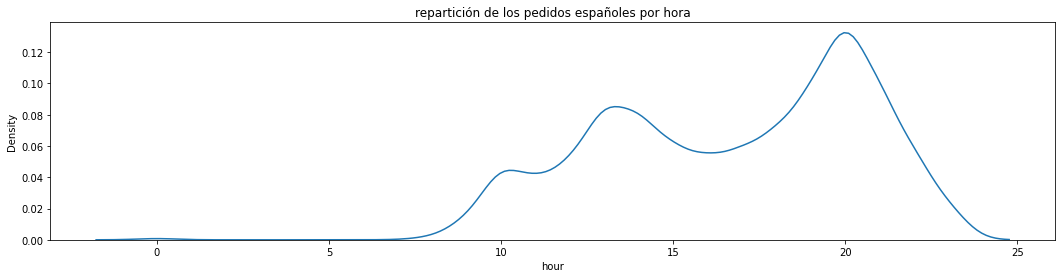

In [25]:
fig, ax = plt.subplots(figsize=(18, 4))
sns.kdeplot(x='hour', data=df_train_espanya)
ax.set_title('repartición de los pedidos españoles por hora')
plt.show()

### datos

In [26]:
# se filtran las 6 horas con más pedidos por ser realitivamente más altas que las otras
frecuencia_horas = df_train_espanya.groupby('hour')['order_id'].count().sort_values(ascending=False).nlargest(6)

In [27]:
# se pasa a Dataframe para poder iterar sobre la serie, al tener un integer como indice no se puede sino 
df_frecuencia_horas = pd.DataFrame(frecuencia_horas)

# se resetea el indice 
df_frecuencia_horas.reset_index(inplace=True)

In [28]:
print('las 6 horas en las que se realizan más pedidos en España son:\n')
for lab, row in df_frecuencia_horas.iterrows():
  print('entre {}h y {}h: {} pedidos'.format(row['hour'],
                                             row['hour']+1,
                                             row['order_id']))

las 6 horas en las que se realizan más pedidos en España son:

entre 20h y 21h: 1716 pedidos
entre 21h y 22h: 1155 pedidos
entre 19h y 20h: 1128 pedidos
entre 13h y 14h: 1047 pedidos
entre 14h y 15h: 956 pedidos
entre 18h y 19h: 821 pedidos


# 3 ¿Cuál es el precio medio por pedido en la tienda con ID 12513?

In [29]:
# se filtra por la tienda, se coge la media de 'products_total y se redondea a 2 decimales
precio_medio_tienda_12513 = round(df_train[df_train['store_address'] == 12513]['products_total'].mean(), 2)

In [30]:
print('el precio medio por pedido en la tienda con ID 12513 es', str(precio_medio_tienda_12513)+'€.')

el precio medio por pedido en la tienda con ID 12513 es 17.39€.


# 4 ¿Qué porcentaje de repartidores pondrías por cada turno para que sean capaces de hacer frente a los picos de demanda?

Teniendo en cuenta los picos de demanda en España, si los repartidores trabajan en turnos de 8horas. Turno 1 (00:00-08:00) Turno 2 (08:00-16:00) Turno 3 (16:00-00:00) Qué porcentaje de repartidores pondrías por cada turno para que sean capaces de hacer frente a los picos de demanda. (ej: Turno 1 el 30%, Turno 2 el 10% y Turno 3 el 60%).

In [31]:
# se definen las horas limites de los turnos
hora8 =  pd.to_datetime('08:00:00')
hora16 =  pd.to_datetime('16:00:00')

In [32]:
# se crea la columna turnos según la hora del pedido
df_train['turno'] = df_train['local_time'].apply(lambda x: 
                                                 'Turno 1' if x < hora8                                                 
                                                 else 
                                                 ('Turno 3' if x >= hora16
                                                  else 'Turno 2'))

In [33]:
# se agrupan los pedidos por turno y se calcula el porcentaje del total de pedidos
porcentaje_turnos = round(df_train['turno'].value_counts(normalize=True).mul(100), 1)

In [34]:
print('la repartición de los turnos es la siguiente:\n')
print('Turno 1 (00:00-08:00):', str(porcentaje_turnos['Turno 1'])+'%')
print('Turno 2 (08:00-16:00):', str(porcentaje_turnos['Turno 2'])+'%')
print('Turno 3 (16:00-00:00):', str(porcentaje_turnos['Turno 3'])+'%')

la repartición de los turnos es la siguiente:

Turno 1 (00:00-08:00): 1.4%
Turno 2 (08:00-16:00): 40.5%
Turno 3 (16:00-00:00): 58.2%


# 5 modelo predictivo

Realiza un modelo predictivo de machine learning a partir del dataset 'train.csv' en el cual a partir de las variables predictoras que se entregan en el dataset 'test_X' se pueda predecir si el pedido se cancelará o no (columna 'final_status').

Es un problema de clasificación binaria sobre la target 'final_status'

In [35]:
# se cambia el valor de 'final_status' por 0 si se canceló o 1 si se entregó
df_train.loc[df_train['final_status'] == 'DeliveredStatus', 'final_status'] = 1
df_train.loc[df_train['final_status'] == 'CanceledStatus', 'final_status'] = 0

# se cambia el tipo de la variable 'final_status' a integer
df_train['final_status'] = df_train['final_status'].astype(int)

## gestión y creación de variables

In [36]:
df_train.head()

,order_id,local_time,store_address,payment_status,n_of_products,products_total,final_status,country,turno
0,33446280,2022-11-08 14:11:09,55379,PAID,2,11.88,1,Argentina,Turno 2
1,33107339,2022-11-08 11:47:41,23487,PAID,2,5.20,1,Guatemala,Turno 2
2,32960645,2022-11-08 11:53:53,62229,PAID,1,6.03,1,Costa Rica,Turno 2
3,32089564,2022-11-08 20:15:21,29446,PAID,6,6.37,1,España,Turno 3
4,32157739,2022-11-08 21:32:16,13917,PAID,1,5.36,0,Argentina,Turno 3


In [37]:
df_test_X.head()

,order_id,local_time,store_address,payment_status,n_of_products,products_total,country
0,32233784,2022-11-08 17:50:09,68169,PAID,1,61.63,Marruecos
1,32240990,2022-11-08 18:38:08,8220,PAID,11,15.99,España
2,33331821,2022-11-08 22:11:59,11169,PAID,4,5.89,Italia
3,33200505,2022-11-08 22:13:55,33371,PAID,3,7.85,Argentina
4,32527480,2022-11-08 12:01:04,33958,PAID,2,4.75,Turquía


### 'order_id'

In [38]:
# se elimina la variable 'order_id' para entrenar pero se guarda los 'order_id' del df_test_X en una variable a parte para volver a incorporarla para el predict
order_id_test = df_test_X['order_id']

df_train.drop('order_id', axis=1, inplace=True)
df_test_X.drop('order_id', axis=1, inplace=True)

### 'hour'

In [39]:
# se crea la variable 'hour' 
df_train['hour'] =  df_train['local_time'].apply(lambda x: x.hour)
df_test_X['hour'] = df_test_X['local_time'].apply(lambda x: x.hour)

### repartición cancelaciones por hora

In [40]:
# se filtran los pedidos cancelados vs entregados
df_cancel = df_train[df_train['final_status'] == 0]
df_entregado = df_train[df_train['final_status'] == 1]

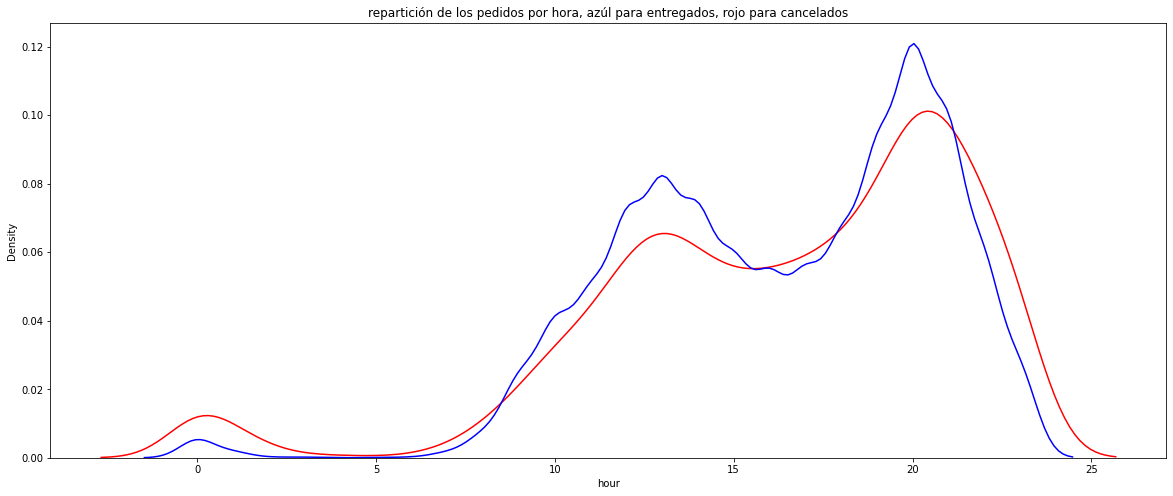

In [41]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.kdeplot(x='hour', data=df_cancel, color='r')
sns.kdeplot(x='hour', data=df_entregado, color='b')
ax.set_title('repartición de los pedidos por hora, azúl para entregados, rojo para cancelados')
plt.show()

### 'pedido_nocturno'

In [42]:
# se crea la variable 'pedido_nocturno' que corresponden a los pedidos hechos entre las 22h00 y la 1h00 de la madrugada, donde parece que es más probable que se cancele.
hora22h00 = pd.to_datetime('22:00:00')
hora1h00 = pd.to_datetime('01:00:00')
df_train['pedido_nocturno'] = df_train['local_time'].apply(lambda x: 
                                                           1 if x >= hora22h00
                                                           else 
                                                           (1 if x < hora1h00
                                                            else 0))
df_test_X['pedido_nocturno'] = df_test_X['local_time'].apply(lambda x: 
                                                           1 if x >= hora22h00
                                                           else 
                                                           (1 if x < hora1h00
                                                            else 0))

### 'avg_final_status_store'

In [43]:
# se crea la variable 'avg_final_status_store' que corresponde a la media de entregados por tienda 
media_final_status_por_tienda = df_train.groupby('store_address')['final_status'].mean()

# se crea un dataframe con las medias por tienda, se añade el index y se cambian los nombres de columnas
df_media_final_status_por_tienda = pd.DataFrame(media_final_status_por_tienda).reset_index()
df_media_final_status_por_tienda.columns = ['store_address', 'avg_final_status_store']

In [44]:
df_media_final_status_por_tienda.head()

,store_address,avg_final_status_store
0,190,1.0
1,191,1.0
2,193,0.0
3,194,0.8
4,196,1.0


In [45]:
# se junta el df_media_final_status_por_tienda con el df_train y se elimina la variable tienda 
df_train = df_train.merge(df_media_final_status_por_tienda, on='store_address', how='left')
df_train.drop('store_address', axis=1, inplace=True)

In [46]:
# se junta el df_media_final_status_por_tienda con el df_text_X y se elimina la variable tienda  
# para verificar que no haya una tienda existente en el df_test que no exista en el df_train
df_test_X = df_test_X.merge(df_media_final_status_por_tienda, on='store_address', how='left')
df_test_X.drop('store_address', axis=1, inplace=True)

### 'turno'

In [47]:
df_train.drop('turno', axis=1, inplace=True)

In [48]:
# se definen las horas limites de los turnos donde parece cambiar la propension a la cancelación
hora1 =  pd.to_datetime('01:00:00')
hora8 =  pd.to_datetime('08:00:00')
hora14 =  pd.to_datetime('15:00:00')
hora18 =  pd.to_datetime('17:00:00')
hora22 =  pd.to_datetime('22:00:00')

In [49]:
# se crea la columna turnos según la hora del pedido
df_train['turno'] = df_train['local_time'].apply(lambda x: 
                                                 'noche' if x < hora1                                                 
                                                 else 
                                                 ('madrugada' if x < hora8
                                                  else 
                                                  ('mañana' if x < hora14
                                                   else
                                                   ('medio dia' if x < hora18
                                                    else
                                                    ('tarde' if x < hora22
                                                     else 'noche')))))
df_test_X['turno'] = df_test_X['local_time'].apply(lambda x: 
                                                 'noche' if x < hora1                                                 
                                                 else 
                                                 ('madrugada' if x < hora8
                                                  else 
                                                  ('mañana' if x < hora14
                                                   else
                                                   ('medio dia' if x < hora18
                                                    else
                                                    ('tarde' if x < hora22
                                                     else 'noche')))))

### 'pico_ventas'

In [50]:
# se definen las horas limites de los turnos de picos
hora1 =  pd.to_datetime('13:00:00')
hora14 =  pd.to_datetime('15:00:00')
hora18 =  pd.to_datetime('18:00:00')
hora22 =  pd.to_datetime('22:00:00')

In [51]:
# se crea la columna turnos según la hora del pedido
df_train['pico_ventas'] = df_train['local_time'].apply(lambda x: 
                                                 0 if x < hora1                                                 
                                                 else 
                                                 (1 if x < hora14
                                                  else 
                                                  (0 if x < hora18
                                                   else
                                                   (1 if x < hora22
                                                    else 0))))
df_test_X['pico_ventas'] = df_test_X['local_time'].apply(lambda x: 
                                                 0 if x < hora1                                                 
                                                 else 
                                                 (1 if x < hora14
                                                  else 
                                                  (0 if x < hora18
                                                   else
                                                   (1 if x < hora22
                                                    else 0))))

### categorizar 'hour'

In [52]:
# se transforma la variable 'hour' a categorica
df_train['hour'] = df_train['hour'].astype('category')
df_test_X['hour'] = df_test_X['hour'].astype('category')

### 'local_time'

In [53]:
# se elimina la variable 'local_time'
df_train.drop('local_time', axis=1, inplace=True)
df_test_X.drop('local_time', axis=1, inplace=True)

## sample

In [54]:
# se filtran los pedidos entregados y los cancelados
entregados = df_train[df_train['final_status'] == 1]
cancelados = df_train[df_train['final_status'] == 0]

In [55]:
# se selecciona de forma aleatoria el mismo número de pedidos entregados que cancelados para equilibrar el dataset, sin posibilidad de repetir pedido
entregados = entregados.sample(len(cancelados), replace=False, random_state=42)

In [56]:
# se juntan los dataframes de entregados y cancelados en el df_train
df_train = pd.concat([entregados, cancelados])

In [57]:
df_train

,payment_status,n_of_products,products_total,final_status,country,hour,pedido_nocturno,avg_final_status_store,turno,pico_ventas
37644,PAID,4,6.45,1,España,16,0,0.934783,medio dia,0
19618,PAID,2,5.65,1,Turquía,19,0,0.600000,tarde,1
8109,PAID,2,7.24,1,Turquía,21,0,0.987654,tarde,1
26542,PAID,1,32.68,1,Rumanía,11,0,1.000000,mañana,0
6158,PAID,13,17.63,1,Marruecos,16,0,0.800000,medio dia,0
...,...,...,...,...,...,...,...,...,...,...
54258,PAID,3,12.53,0,Argentina,19,0,0.333333,tarde,1
54272,PAID,1,10.90,0,Francia,19,0,0.943396,tarde,1
54284,PAID,2,21.50,0,España,20,0,0.000000,tarde,1
54290,PAID,1,2.01,0,Egipto,20,0,0.944444,tarde,1


In [58]:
df_test_X

,payment_status,n_of_products,products_total,country,hour,pedido_nocturno,avg_final_status_store,turno,pico_ventas
0,PAID,1,61.63,Marruecos,17,0,0.000000,tarde,0
1,PAID,11,15.99,España,18,0,0.956522,tarde,1
2,PAID,4,5.89,Italia,22,1,0.789474,noche,0
3,PAID,3,7.85,Argentina,22,1,0.666667,noche,0
4,PAID,2,4.75,Turquía,12,0,1.000000,mañana,0
5,PAID,2,14.28,Ecuador,11,0,1.000000,mañana,0
6,PAID,5,14.35,España,18,0,0.965517,tarde,1
7,PAID,2,4.42,Turquía,20,0,0.875000,tarde,1
8,NOT_PAID,2,1.79,Marruecos,18,0,0.500000,tarde,1
9,PAID,5,29.89,Panamá,13,0,0.976190,mañana,1


## analisis del target

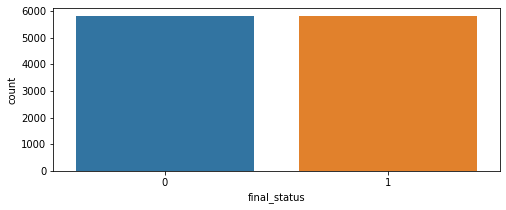

In [59]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.countplot(data=df_train, x='final_status')
plt.show()

In [60]:
df_train['final_status'].value_counts(normalize=True).mul(100)

1    50.0
0    50.0
Name: final_status, dtype: float64

el data set esta equilibrado entre entregados y cancelados

## correlaciones

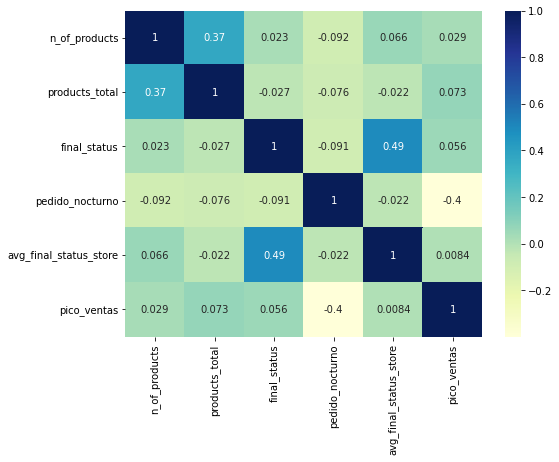

In [61]:
plt.rcParams['figure.figsize'] = 8, 6
sns.heatmap(df_train.corr(), annot=True, cmap="YlGnBu")
plt.show()

La media de final estatus por tienda parece la variable que aporta más valor al modelo. La variable pedido_nocturno influye negativamente sobre el target. 

## one hot encoding

In [62]:
df_train = pd.get_dummies(df_train)

In [63]:
df_train.shape

(11664, 61)

In [64]:
df_test_X = pd.get_dummies(df_test_X)

In [65]:
df_test_X.shape

(30, 36)

## filtro de las columnas según df_test_X

se guardan las mismas columnas para df_train que las que tiene df_test_X para poder entrenar con las mismas variables que tendremos para la predicción

In [66]:
# se consiguen las columnas de df_test_X
columnas = df_test_X.columns

In [67]:
# para df_train, se guarda el target y se eliminan las columnas que no forman parte de df_test_X
target = df_train['final_status']
df_train = df_train[columnas]

In [68]:
# se comprueba que los 2 datasets tienen el mismo número de columnas
df_train.shape[1] == df_test_X.shape[1]

True

In [69]:
# se vuelve a introducir el target en df_train
df_train['final_status'] = target

## feature importance

In [70]:
params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

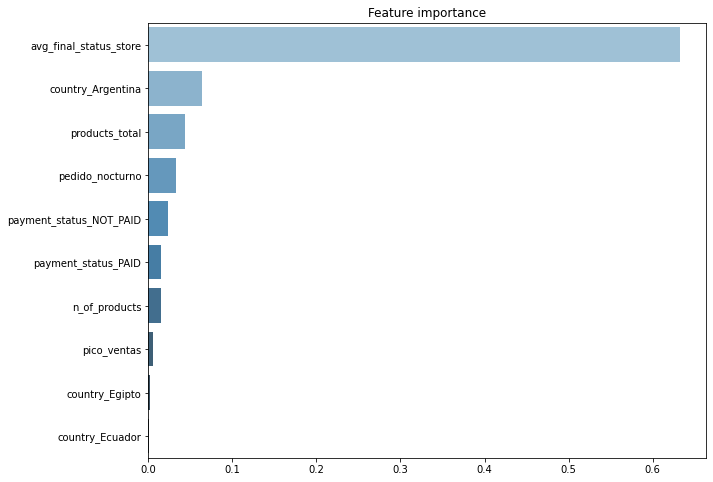

In [71]:
# se entrena un RandomForest y se plotean las variables que tuvieron más importancia en el modelo
y = df_train['final_status']
x = df_train.drop('final_status' ,axis=1)
# entrena un RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)
# Plotea las 15 mejores Features importances
features = clf.feature_importances_[:10]
columnas = x.columns[:10]
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)
plt.figure(figsize=(10,8))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')
plt.show()

## split train/test

In [72]:
# se guarda un 30% de datos para el test y un 70% para el train 
y = df_train['final_status']
X = df_train.drop('final_status', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [73]:
X_train.shape

(8164, 36)

## estandarización

In [74]:
# se estandarizan las variables para evitar sesgo
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # estandariza y define la regla de estandarización
X_test = scaler.transform(X_test)         # estandariza según la regla definida con el X_train

df_test_X = scaler.transform(df_test_X)

## modelado

In [75]:
def medicion(y_t, y_p):
  """imprime la curva ROC y el AUC"""

  # calculate the fpr and tpr for all thresholds of the classification
  fpr, tpr, threshold = metrics.roc_curve(y_t, y_p)
  roc_auc = metrics.auc(fpr, tpr)

  # method I: plt
  import matplotlib.pyplot as plt
  plt.figure(figsize=(8, 6))
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return roc_auc

In [76]:
def entrenar(Xtrain, Xtest, ytrain, ytest):
  """entrena 6 módelos.
      imprime la curva roc de cada módelo junto al valor AUC
      devuelve un dataframe con los valores de AUC redondeados a 5 decimales para cada módelo"""

  # creamos la lista de auc vacía
  lista_aucs = []

  # Support Vector Machine
  print('Support Vector Machine')
  svclassifier = SVC(max_iter=20)

  svclassifier.fit(Xtrain, ytrain)
  y_pred = svclassifier.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('SVC', round(roc_auc, 5)))
  print('*'*80)

  # Regresión logística
  print('Regresión logística')
  lr = LogisticRegression(max_iter=40)

  lr.fit(Xtrain, ytrain)
  y_pred = lr.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('regresión logística', round(roc_auc, 5)))
  print('*'*80)

  # Decision tree classsifier
  print('Decision tree classsifier')
  dt_base = DecisionTreeClassifier(random_state=42)

  dt_base.fit(Xtrain, ytrain)
  y_pred = dt_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('decision tree classifier', round(roc_auc, 5)))
  print('*'*80)

  # Random forest
  print('Random forest')
  rf_base = RandomForestClassifier(random_state=42)

  rf_base.fit(Xtrain, ytrain)
  y_pred = rf_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('random forest', round(roc_auc, 5)))
  print('*'*80)

  # Gradient boosting
  print('Gradient boosting')
  gbc_base = GradientBoostingClassifier(random_state=42)

  gbc_base.fit(Xtrain, ytrain)
  y_pred = gbc_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('gradient boosting', round(roc_auc, 5)))
  print('*'*80)

  # XGBClassifier
  print('XGBClassifier')
  xgbc_base = xgb.XGBClassifier(random_state=42)

  xgbc_base.fit(Xtrain, ytrain)
  y_pred = xgbc_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('XGB classifier', round(roc_auc, 5)))
  print('*'*80)

  df_aucs = pd.DataFrame(lista_aucs, columns=['modelos', 'AUC'])
  df_aucs = df_aucs.set_index('modelos')
  
  return df_aucs

Support Vector Machine


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


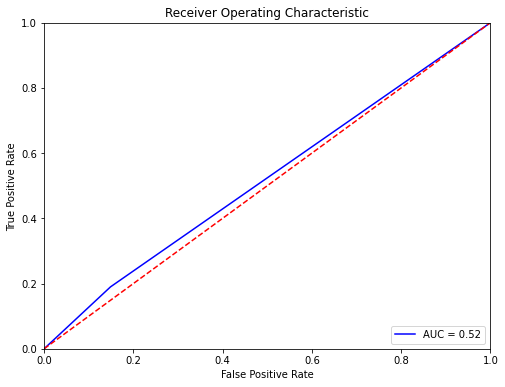

********************************************************************************
Regresión logística


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


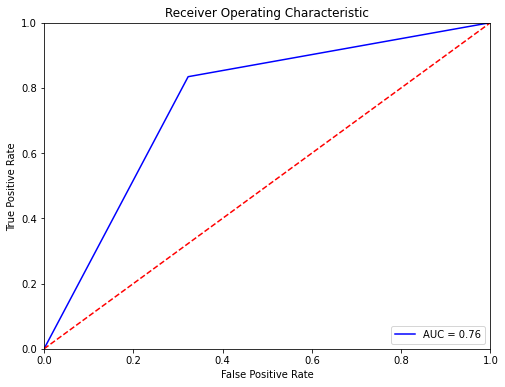

********************************************************************************
Decision tree classsifier


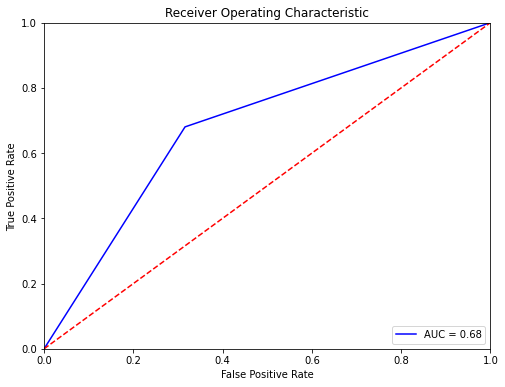

********************************************************************************
Random forest


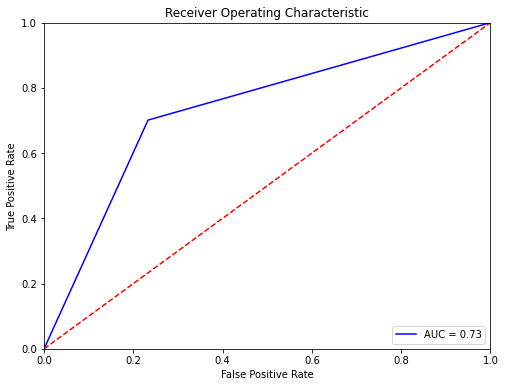

********************************************************************************
Gradient boosting


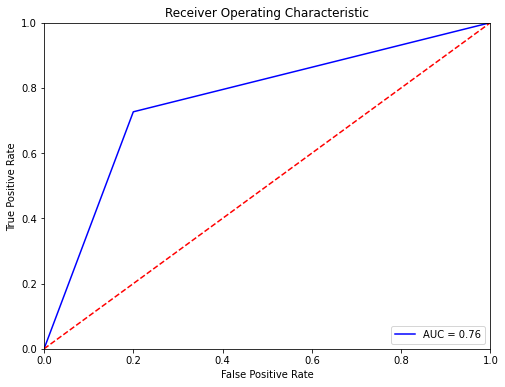

********************************************************************************
XGBClassifier


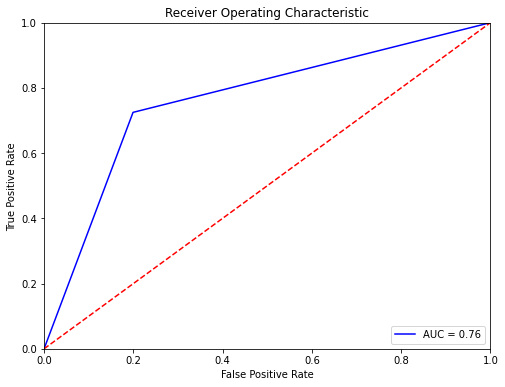

********************************************************************************


In [77]:
aucs = entrenar(X_train, X_test, y_train, y_test)

## AUCS

In [78]:
aucs

,AUC
modelos,
SVC,0.52053
regresión logística,0.75578
decision tree classifier,0.68231
random forest,0.73417
gradient boosting,0.76336
XGB classifier,0.76281


El modelo más acertado de base es el gradient boosting con un AUC de 0.76336

## gridsearch

In [79]:
# gridsearch
parameters = {'learning_rate': [0.05, 0.1, 0.15],
              'n_estimators': [100,300, 500],
              'subsample': [0.7],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [3, 4, 5],
              'max_leaf_nodes': [None, 2, 3]}

In [80]:
gbc_hp =  GradientBoostingClassifier()

In [81]:
gbc_grid = GridSearchCV(gbc_hp,
                        parameters,
                        cv=2,
                        verbose=True)

gbc_grid.fit(X_train, y_train)

Fitting 2 folds for each of 243 candidates, totalling 486 fits


GridSearchCV(cv=2, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [3, 4, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [None, 2, 3],
                         'n_estimators': [100, 300, 500], 'subsample': [0.7]},
             verbose=True)

In [82]:
# se imprime el modelo con los mejores parametros 
gbc_grid.best_estimator_

GradientBoostingClassifier(max_depth=5, max_features='log2', max_leaf_nodes=3,
                           n_estimators=300, subsample=0.7)

In [83]:
# se introducen los parametros del griedsearch
gbc = GradientBoostingClassifier(max_depth=5, max_features='log2', max_leaf_nodes=3,
                           n_estimators=300, subsample=0.7)

gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

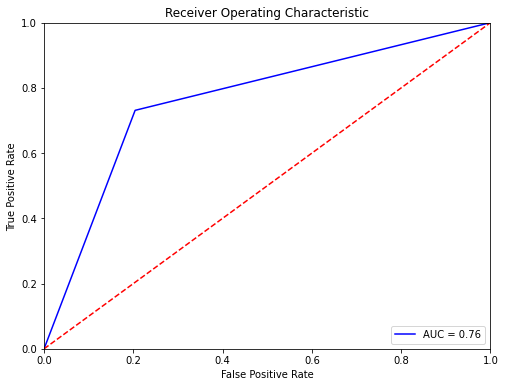

0.7635881883417093


In [84]:
roc_auc = medicion(y_test, y_pred)
print(roc_auc)

## predict

ya se ha realizado el mismo preprocessing para df_test_X que para df_train sobre el tratamiento de las columnas

In [85]:
df_test_X.shape

(30, 36)

In [86]:
# se hace la predicción
pred = gbc.predict(df_test_X)

In [87]:
pred

array([0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0])

In [88]:
# se crea un dataframe con la predicción
df_pred = pd.DataFrame(pred, columns=['final_status'])

In [89]:
df_pred

,final_status
0,0
1,1
2,0
3,0
4,1
5,1
6,1
7,0
8,0
9,1


In [90]:
# se exporta a csv
df_pred.to_csv('predicción_Mathieu_Debrabander.csv')